In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import RFE
import shap

In [3]:
# Load the cleaned dataset
df1 = pd.read_excel(r"/content/Annotated_WEAR_7001_7015_deID.xlsx", header=0)
df2 = pd.read_excel(r"/content/Annotated_WEAR_7016_7030_deID.xlsx", header=0)
df = pd.concat([df1, df2], ignore_index=True)

In [4]:
# Data Cleaning - handling 'Days in relation to CAR-T infusion' column
df['Days in relation to CAR-T  infusion'] = df['Days in relation to CAR-T  infusion'].replace({
    'Baseline': 0,          # Replace 'Baseline' with 0
    '2hr Post': 2 / 24,     # Convert '2hr Post' to 0.083 (fraction of a day)
    '4hr Post': 4 / 24,     # Convert '4hr Post' to 0.167 (fraction of a day)
    '6hr Post': 6 / 24,     # Convert '6hr Post' to 0.25 (fraction of a day)
    '8hr Post': 8 / 24      # Convert '8hr Post' to 0.333 (fraction of a day)
})

df_clean = df.dropna(how='all')
df_clean.columns  = df_clean.columns.str.strip()  # Remove leading/trailing spaces from column names

df_clean.loc[:, 'Days in relation to CAR-T  infusion'] = pd.to_numeric(df_clean['Days in relation to CAR-T  infusion'], errors='coerce')

# Sort the dataframe by 'PT_ID' and 'Days in relation to CAR-T infusion'
df_clean = df_clean.sort_values(by=['PT_ID', 'Days in relation to CAR-T  infusion'], ascending=[True, True])

# Print the first few rows of the sorted dataframe to verify
print(df_clean.head())

   Wearable Device ID      Sample ID   PT_ID Agent (JNJ/BMS/Caribou)  \
0                 NaN   WEAR_7001_V1  7001.0                     BMS   
1                 NaN  WEAR_7001_CRS  7001.0                     BMS   
2                 NaN   WEAR_7001_V6  7001.0                     BMS   
3                 NaN   WEAR_7001_V7  7001.0                     BMS   
4                 NaN   WEAR_7001_V8  7001.0                     BMS   

  Date of CAR-T infusion        DOB        Age Date of Sample  \
0               10/21/22 1939-11-16  82.986301     2022-10-21   
1               10/21/22 1939-11-16  82.986301     2022-10-22   
2               10/21/22 1939-11-16  82.986301     2022-10-22   
3               10/21/22 1939-11-16  82.986301     2022-10-23   
4               10/21/22 1939-11-16  82.986301     2022-10-24   

  Days in relation to CAR-T  infusion  \
0                                 0.0   
1                                 1.0   
2                                 1.0   
3           

In [5]:
# Define biomarkers for analysis
biomarkers = ['IL6', 'IL10', 'TNF', 'GZMB', 'CD83', 'CSF-1']

# Group data by PT_ID
grouped = df_clean.groupby('PT_ID')


# Function to calculate deviations and rate of change safely
def calculate_patient_deviation_trend(group, biomarkers):
    group['Days in relation to CAR-T  infusion'] = pd.to_numeric(group['Days in relation to CAR-T  infusion'], errors='coerce')

    # Identify baseline values (Day 0)
    base_values = group.loc[group['Days in relation to CAR-T  infusion'] == 0]
    if base_values.empty:
        return None  # Skip if no baseline

    base_values = base_values.iloc[0]

    # Initialize columns for storing deviations and rate of change
    for biomarker in biomarkers:
        if biomarker in group.columns:
            group[f'{biomarker}_deviation'] = group[biomarker] - base_values[biomarker]

            # Safely calculate rate of change, avoiding division by zero
            group['day_diff'] = group['Days in relation to CAR-T  infusion'].diff().replace(0, np.nan)  # Replace zero with NaN to prevent division by zero
            group[f'{biomarker}_rate_of_change'] = group[f'{biomarker}_deviation'].diff() / group['day_diff']

            # Replace any NaN values generated by division by zero or missing days
            group[f'{biomarker}_rate_of_change'].fillna(0, inplace=True)
        else:
            group[f'{biomarker}_deviation'] = None
            group[f'{biomarker}_rate_of_change'] = None

    return group

# Apply the above function to each patient group
patient_data = []
for pt_id, group in grouped:
    print(f"Analyzing Patient: {pt_id}")
    group_with_features = calculate_patient_deviation_trend(group, biomarkers)
    if group_with_features is not None:
        patient_data.append(group_with_features)

# Combine all patient data back into a single dataframe
df_patient_deviation = pd.concat(patient_data)

# Verify the feature engineered data
print(df_patient_deviation.head())

Analyzing Patient: 7001.0
Analyzing Patient: 7002.0
Analyzing Patient: 7003.0
Analyzing Patient: 7004.0
Analyzing Patient: 7005.0
Analyzing Patient: 7006.0
Analyzing Patient: 7007.0
Analyzing Patient: 7008.0
Analyzing Patient: 7009.0
Analyzing Patient: 7010.0
Analyzing Patient: 7011.0
Analyzing Patient: 7012.0
Analyzing Patient: 7013.0
Analyzing Patient: 7014.0
Analyzing Patient: 7015.0
Analyzing Patient: 7016.0
Analyzing Patient: 7017.0
Analyzing Patient: 7018.0
Analyzing Patient: 7019.0
Analyzing Patient: 7020.0
Analyzing Patient: 7021.0
Analyzing Patient: 7022.0
Analyzing Patient: 7023.0
Analyzing Patient: 7024.0
Analyzing Patient: 7025.0
Analyzing Patient: 7026.0
Analyzing Patient: 7027.0
Analyzing Patient: 7028.0
Analyzing Patient: 7029.0
Analyzing Patient: 7030.0
   Wearable Device ID      Sample ID   PT_ID Agent (JNJ/BMS/Caribou)  \
0                 NaN   WEAR_7001_V1  7001.0                     BMS   
1                 NaN  WEAR_7001_CRS  7001.0                     BMS   
2   

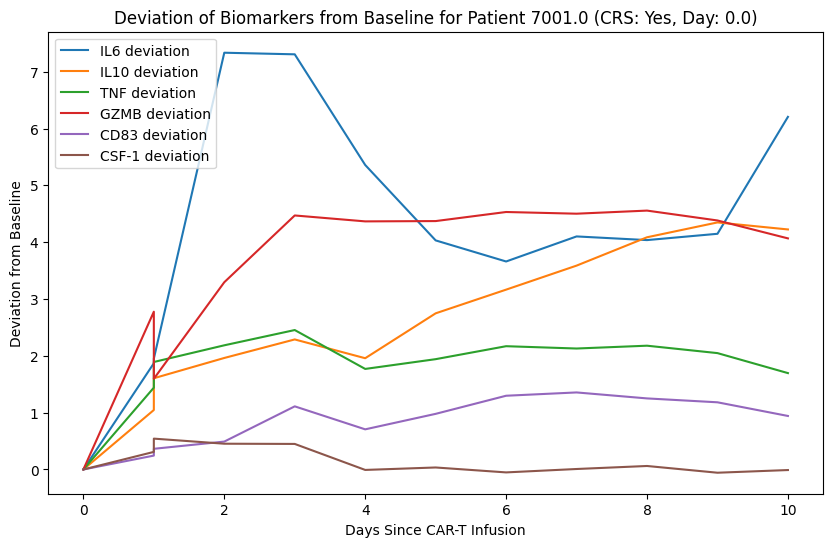

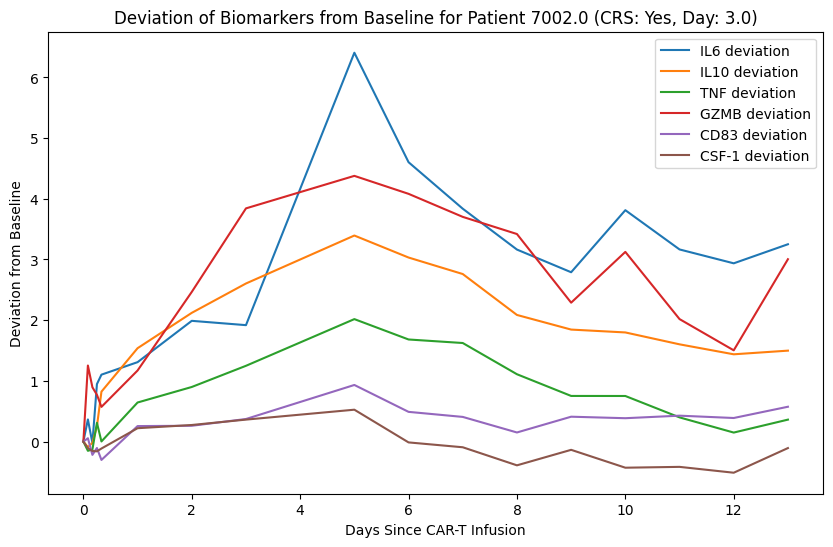

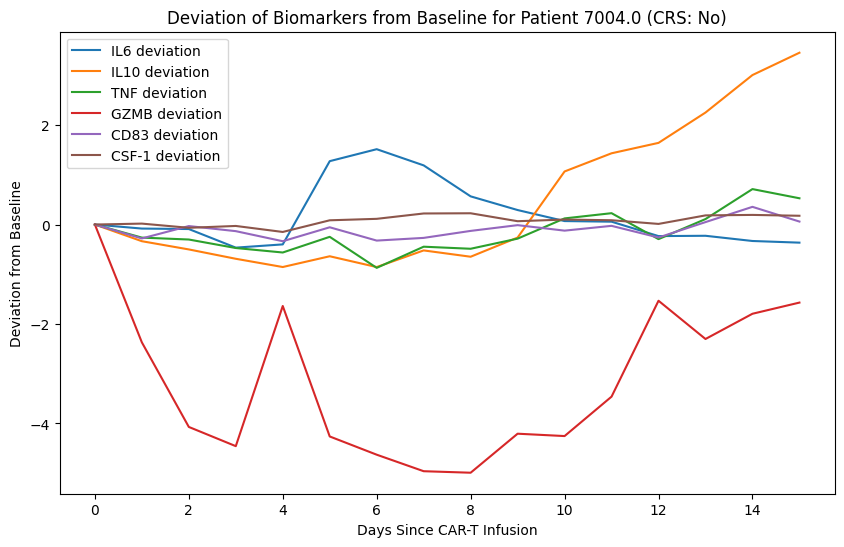

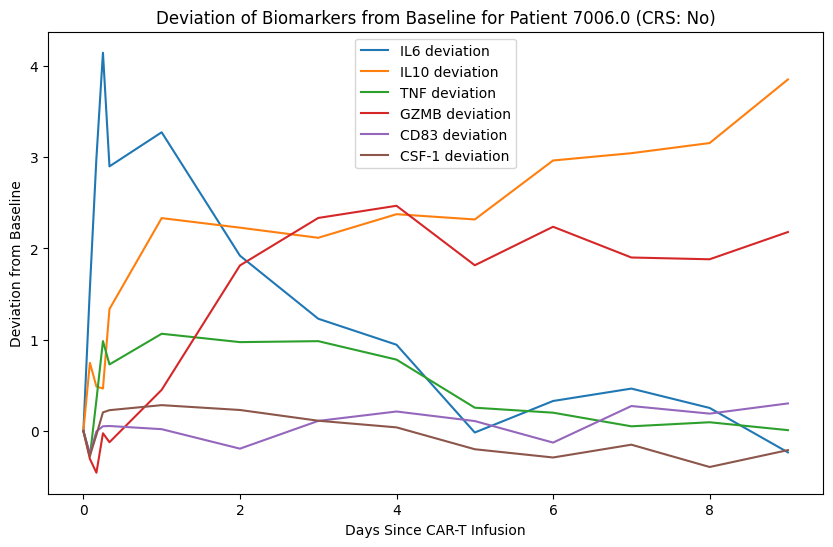

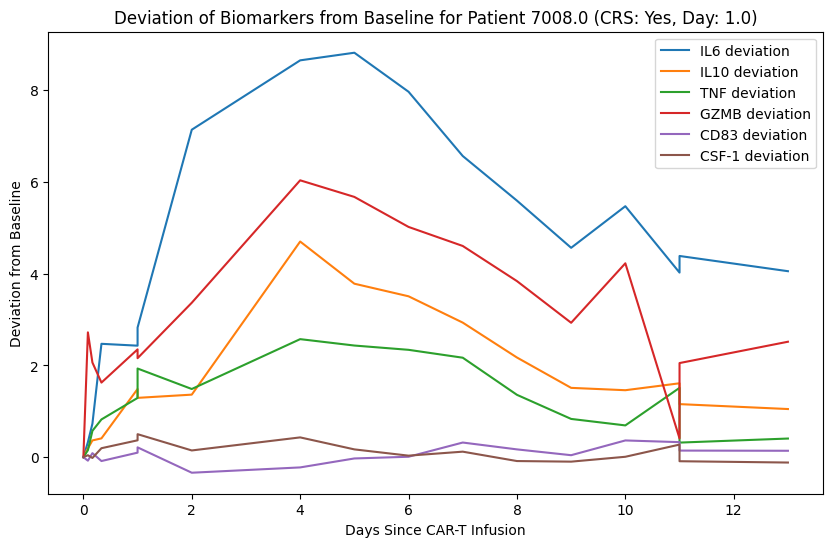

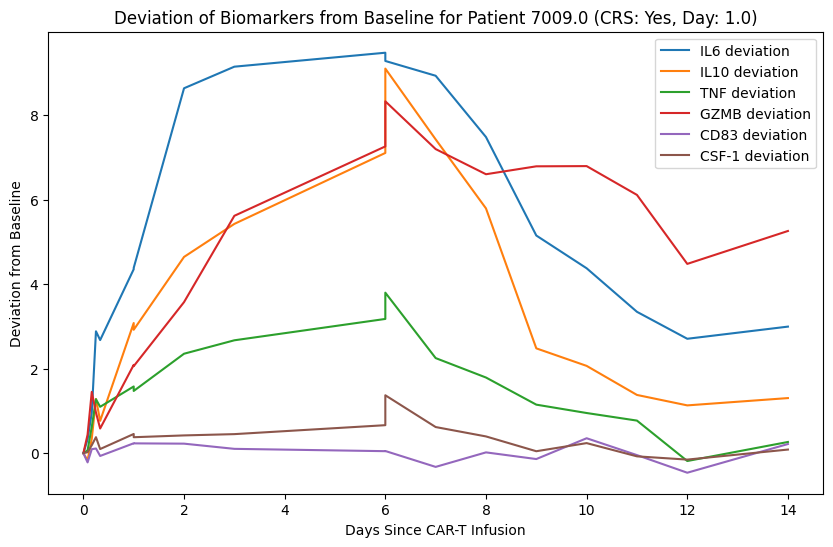

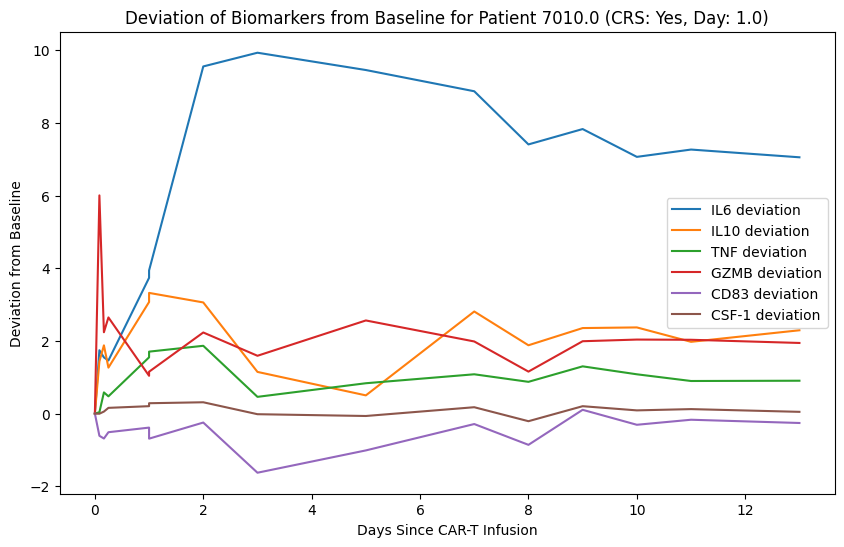

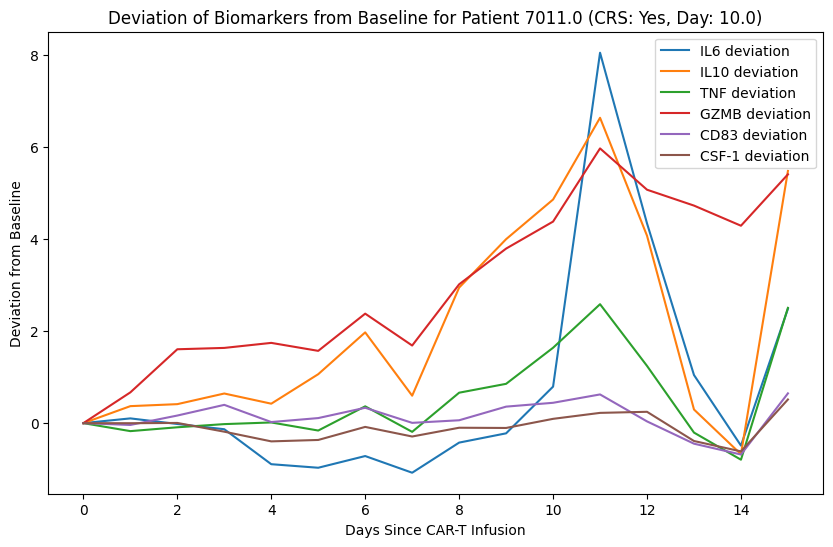

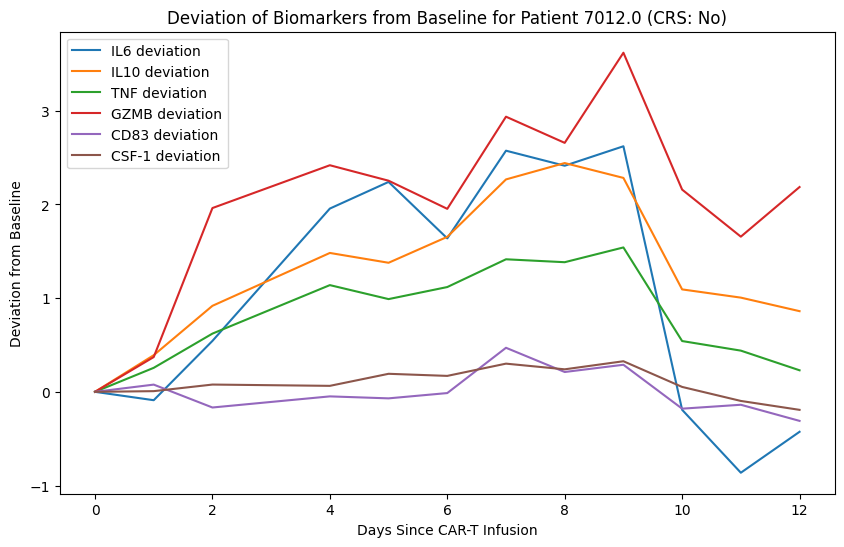

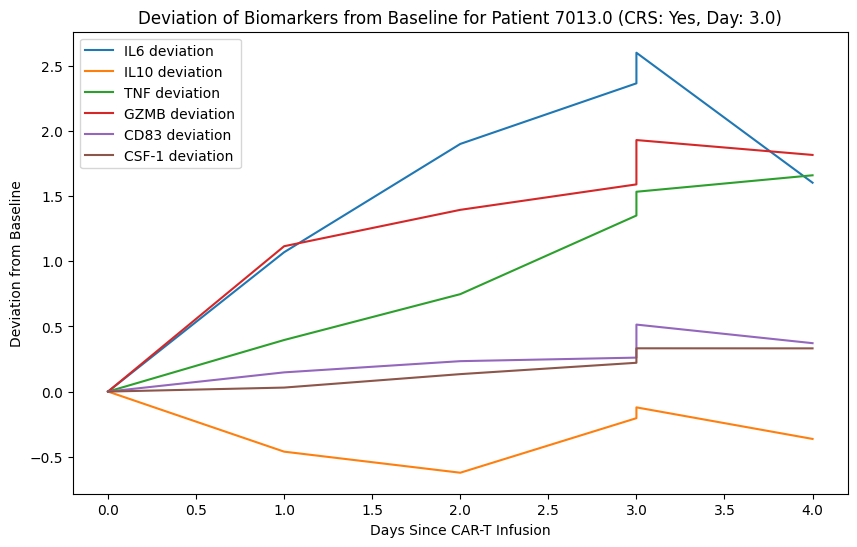

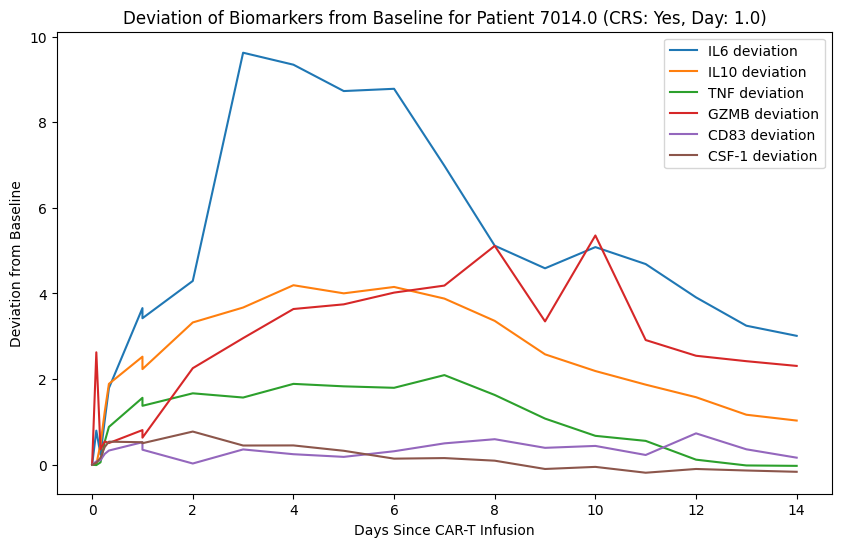

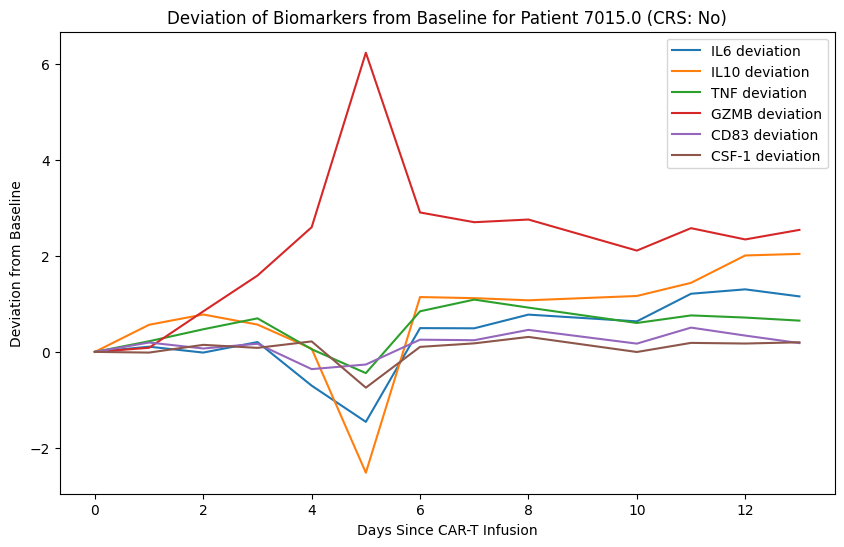

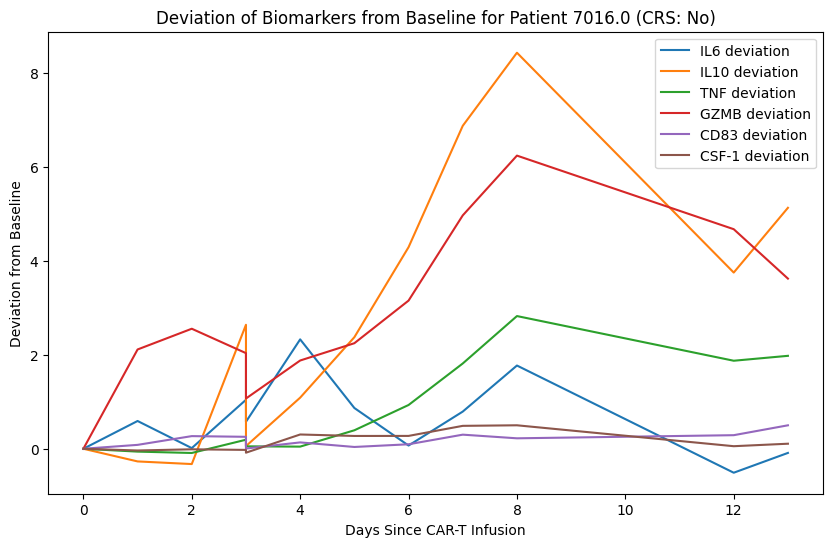

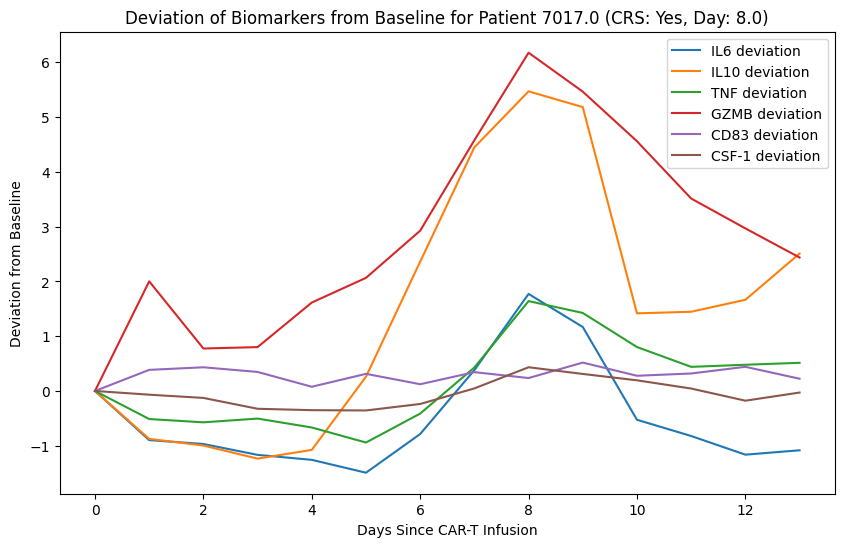

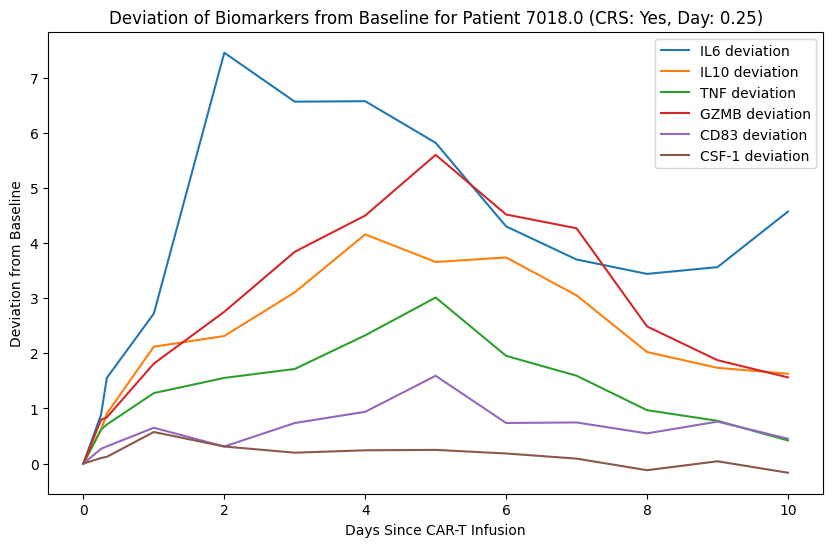

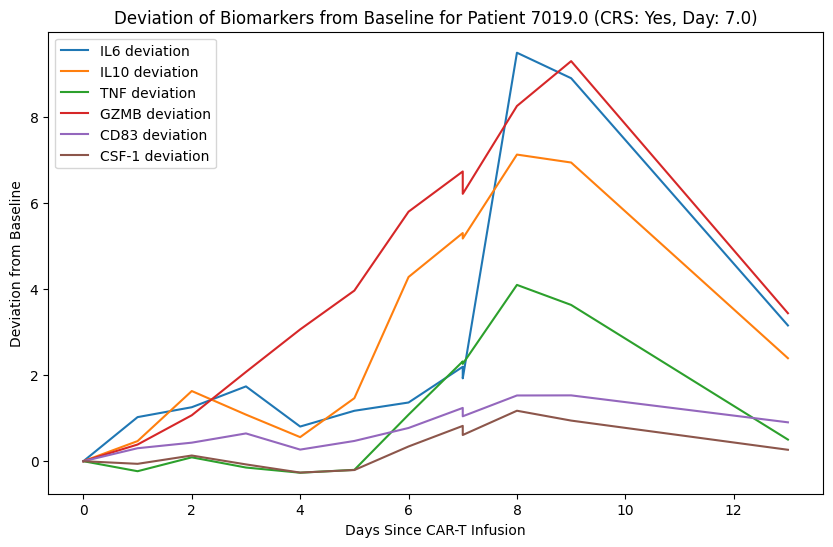

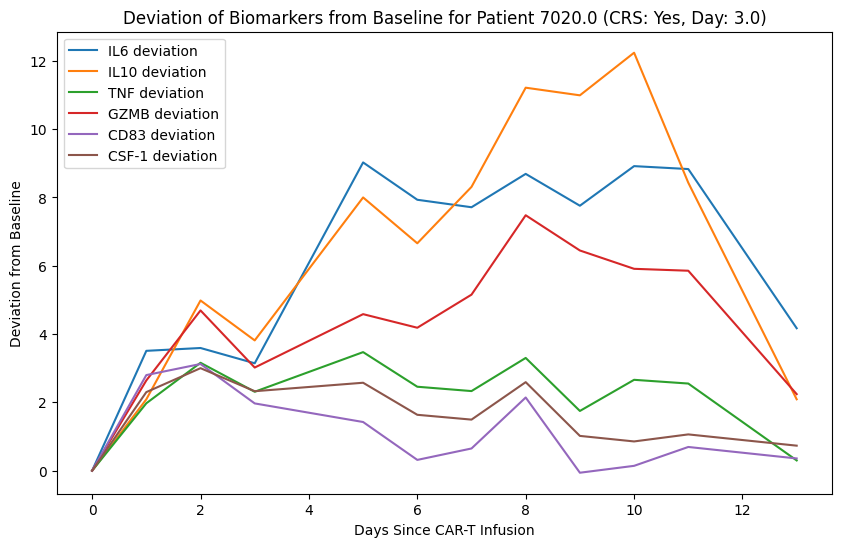

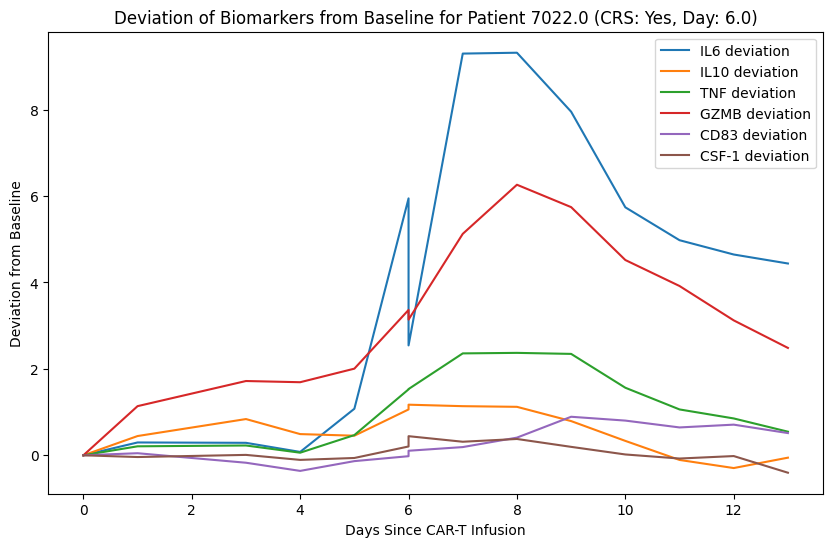

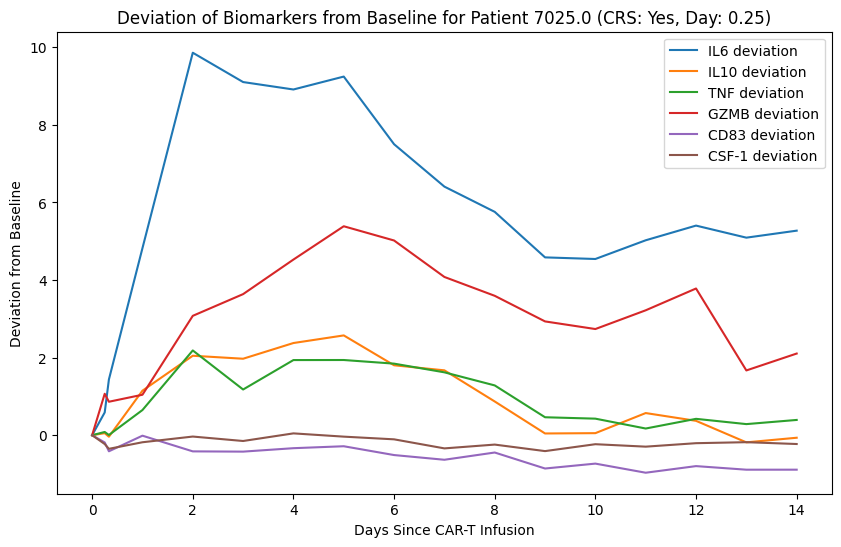

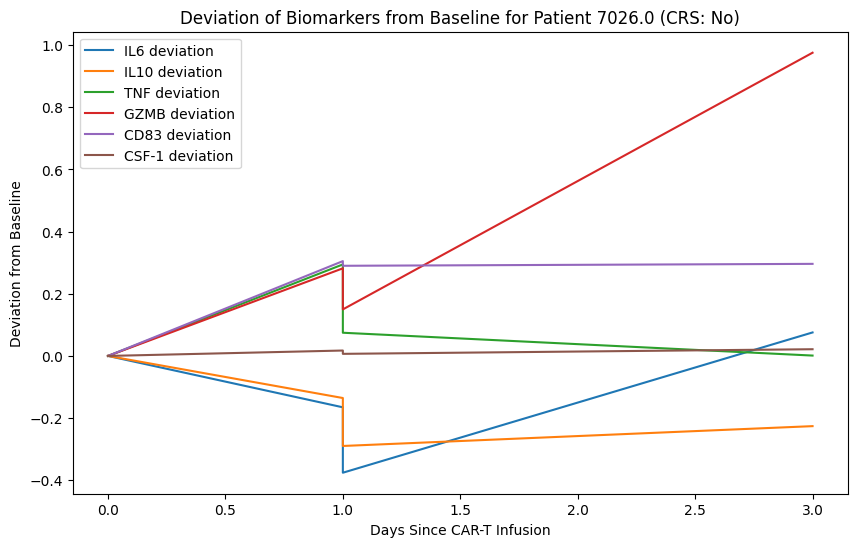

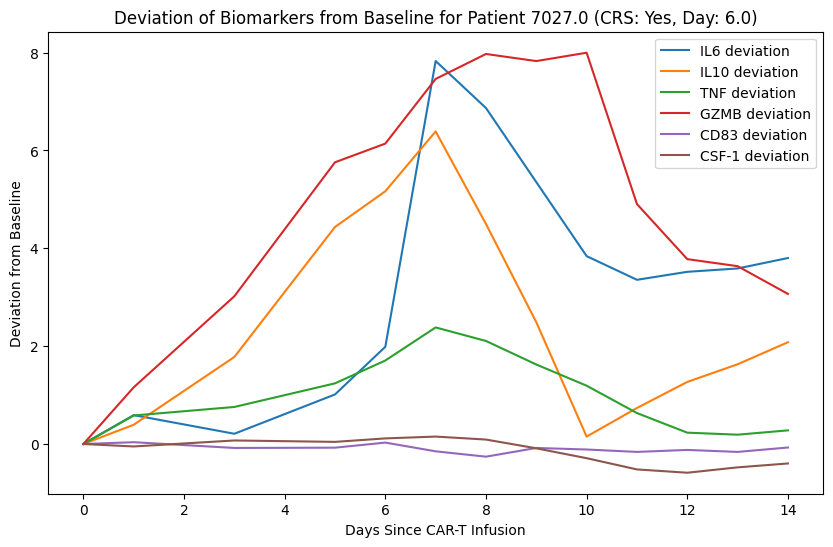

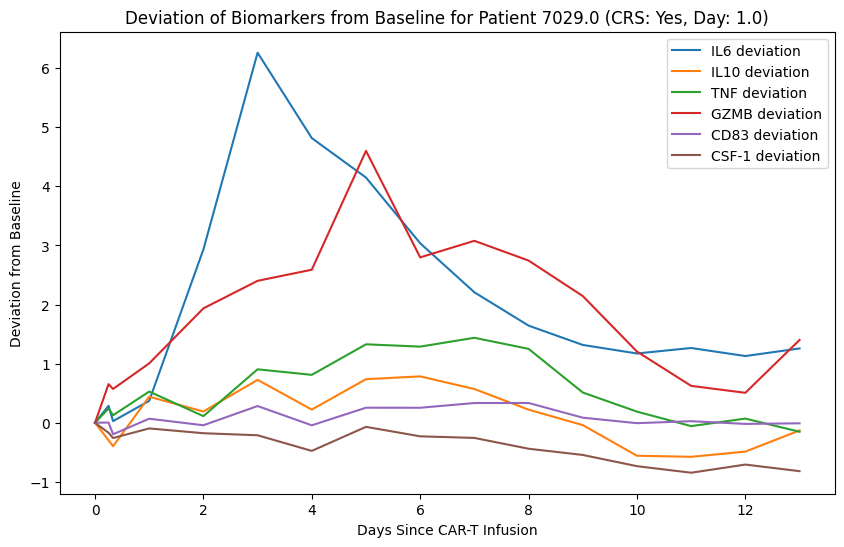

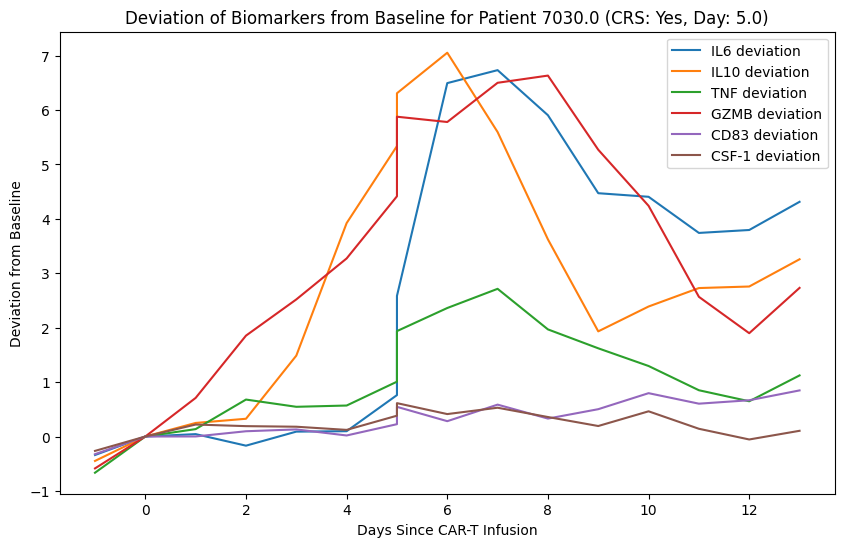

In [6]:
# Plot the deviations over time for each patient
for pt_id, group in df_patient_deviation.groupby('PT_ID'):
    crs_status = group['CRS on date (0 No, 1 Yes)'].max()  # If the max is 1, the patient experienced CRS
    crs_onset_day = group.loc[group['CRS on date (0 No, 1 Yes)'] == 1, 'Days in relation to CAR-T  infusion'].min() if crs_status == 1 else None

    plt.figure(figsize=(10, 6))
    for biomarker in biomarkers:
        if f'{biomarker}_deviation' in group.columns:
            plt.plot(group['Days in relation to CAR-T  infusion'], group[f'{biomarker}_deviation'], label=f'{biomarker} deviation')

    if crs_status == 1:
        title = f"Deviation of Biomarkers from Baseline for Patient {pt_id} (CRS: Yes, Day: {crs_onset_day})"
    else:
        title = f"Deviation of Biomarkers from Baseline for Patient {pt_id} (CRS: No)"

    plt.title(title)
    plt.xlabel('Days Since CAR-T Infusion')
    plt.ylabel('Deviation from Baseline')
    plt.legend()
    plt.show()

In [7]:
def extract_patient_features(group, biomarkers):
    feature_row = {'PT_ID': group['PT_ID'].iloc[0]}

    for biomarker in biomarkers:
        feature_row[f'max_{biomarker}_deviation'] = group[f'{biomarker}_deviation'].max()
        feature_row[f'rate_of_change_{biomarker}'] = group[f'{biomarker}_rate_of_change'].mean()

    feature_row['CRS_status'] = group['CRS on date (0 No, 1 Yes)'].max()

    return feature_row

# Extract features for each patient
patient_features = [extract_patient_features(group, biomarkers) for pt_id, group in df_patient_deviation.groupby('PT_ID')]

# Convert the patient features into a dataframe for modeling
df_patient_features = pd.DataFrame(patient_features)
print(df_patient_features.head())

    PT_ID  max_IL6_deviation  rate_of_change_IL6  max_IL10_deviation  \
0  7001.0            7.33368            0.510268             4.34725   
1  7002.0            6.40687            0.778491             3.39472   
2  7004.0            1.51524           -0.022758             3.45524   
3  7006.0            4.14577            2.275269             3.85262   
4  7008.0            8.81837            1.142969             4.70172   

   rate_of_change_IL10  max_TNF_deviation  rate_of_change_TNF  \
0             0.305417            2.45361            0.103695   
1             0.617924            2.01748            0.018575   
2             0.215952            0.71286            0.033014   
3             1.360639            1.06545            0.585690   
4             0.286154            2.57375            0.480482   

   max_GZMB_deviation  rate_of_change_GZMB  max_CD83_deviation  \
0             4.55549             0.437258             1.35568   
1             4.37779             0.548281  

In [8]:
# Handle any remaining missing values
df_patient_features.fillna(0, inplace=True)

# Separate features and target
X = df_patient_features.drop(['PT_ID', 'CRS_status'], axis=1)
y = df_patient_features['CRS_status']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize/scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.75      0.75      0.75         4

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5

ROC-AUC Score: 0.375


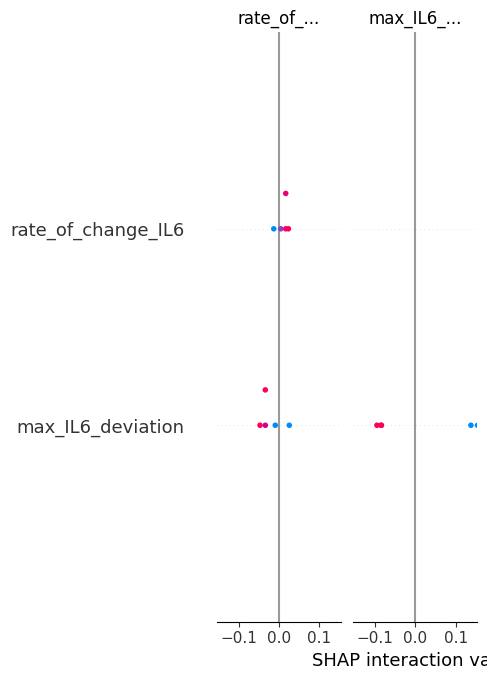

In [9]:
# SHAP values to interpret the importance of each feature
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot of SHAP values (use shap_values directly for binary classification)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)





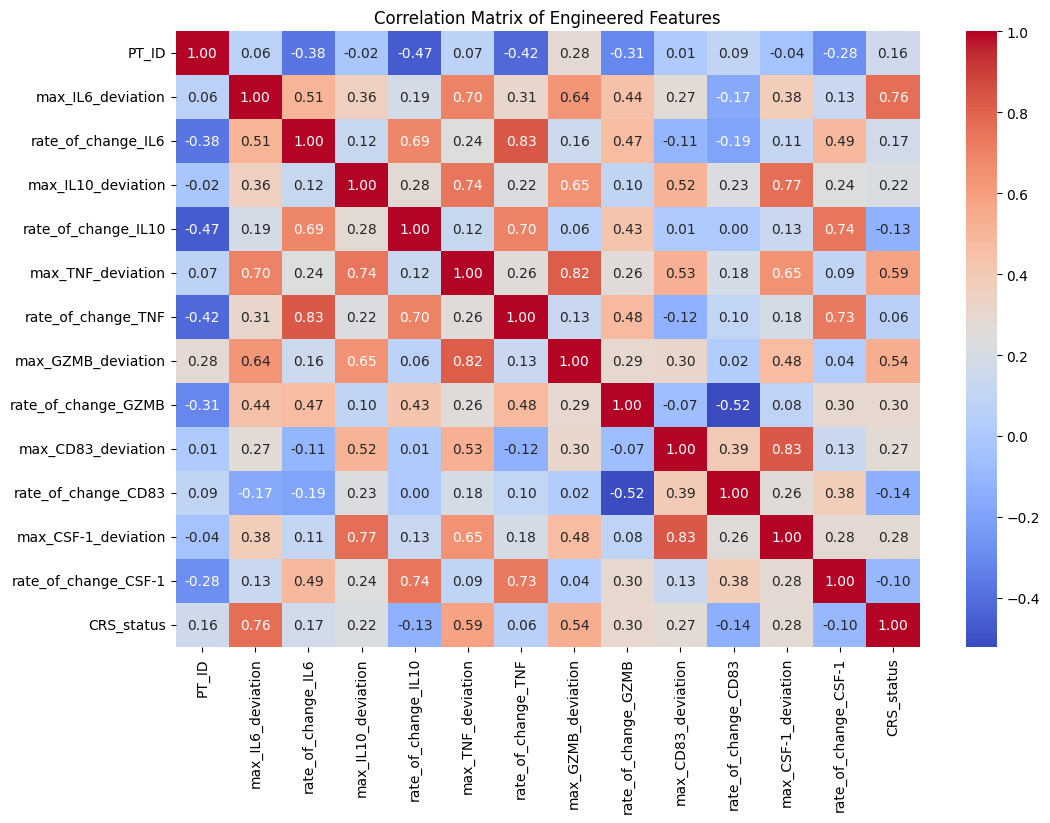

In [10]:
# Correlation matrix to identify redundant features
plt.figure(figsize=(12, 8))
corr_matrix = df_patient_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Engineered Features')
plt.show()

In [11]:
threshold = 0.85
correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            correlated_features.add(corr_matrix.columns[i])

print(f"Highly correlated features to remove: {correlated_features}")

# Drop the highly correlated features from the dataset
df_patient_features.drop(columns=correlated_features, inplace=True)


Highly correlated features to remove: set()


In [12]:
# Initialize Recursive Feature Elimination
rfe = RFE(estimator=rf_model, n_features_to_select=5)  # Select top 5 features

# Fit RFE to the training data
rfe.fit(X_train_scaled, y_train)

# Check which features were selected
selected_features = X.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# Retrain the model with only the selected features
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

rf_model.fit(X_train_selected, y_train)

# Make predictions on the selected features
y_pred_rfe = rf_model.predict(X_test_selected)

# Evaluate the model with selected features
print("Accuracy (RFE-selected features):", accuracy_score(y_test, y_pred_rfe))
print("ROC-AUC Score (RFE-selected features):", roc_auc_score(y_test, y_pred_rfe))

Selected features by RFE: Index(['max_IL6_deviation', 'rate_of_change_IL6', 'max_TNF_deviation',
       'max_GZMB_deviation', 'rate_of_change_CD83'],
      dtype='object')
Accuracy (RFE-selected features): 0.8
ROC-AUC Score (RFE-selected features): 0.5


In [14]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit GridSearchCV to training data
grid_search.fit(X_train_scaled, y_train)

# Assign the best estimator to best_rf_model
best_rf_model = grid_search.best_estimator_

# Display the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate model on the test set
y_pred_best = best_rf_model.predict(X_test_scaled)
print("Accuracy (best hyperparameters):", accuracy_score(y_test, y_pred_best))
print("ROC-AUC Score (best hyperparameters):", roc_auc_score(y_test, y_pred_best))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy (best hyperparameters): 0.6
ROC-AUC Score (best hyperparameters): 0.375


  0%|          | 0/5 [00:00<?, ?it/s]

SHAP values shape: (5, 12)


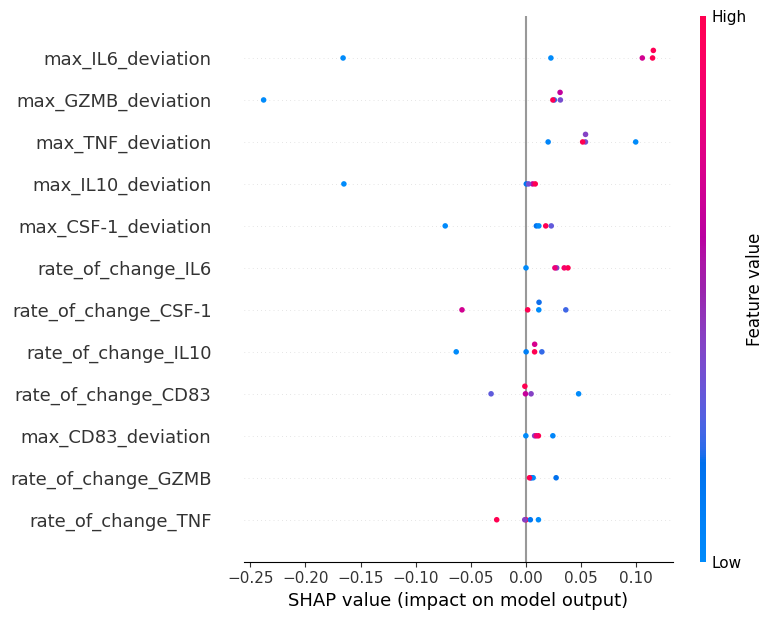

Most impactful feature index: 0
Most impactful feature name: max_IL6_deviation


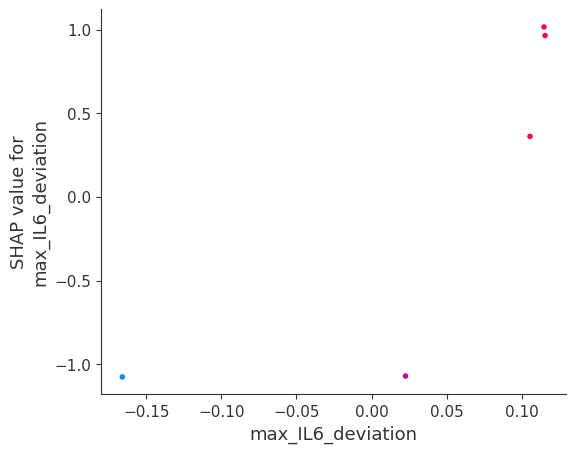

In [15]:
import shap

# Subsample the test set to speed up SHAP calculations
X_test_sample = X_test_scaled[:100]

# Use KernelExplainer to get SHAP values
explainer_kernel = shap.KernelExplainer(best_rf_model.predict, X_train_scaled[:100])  # Use a small subset for the background data

# Compute SHAP values for the subsampled test data
shap_values_kernel = explainer_kernel.shap_values(X_test_sample)

# Confirm the shape of SHAP values
print("SHAP values shape:", np.shape(shap_values_kernel))

# SHAP summary plot for the subsampled test set
shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=X.columns)

# Identify the most impactful feature
most_impactful_feature_index = np.argmax(np.abs(shap_values_kernel).mean(0))
print("Most impactful feature index:", most_impactful_feature_index)
print("Most impactful feature name:", X.columns[most_impactful_feature_index])

# SHAP dependence plot for the most important feature
shap.dependence_plot(most_impactful_feature_index, X_test_sample, shap_values_kernel, feature_names=X.columns)
